# Decision Dependent Games Simulation
## Uber vs. Lyft

We introduce fictional performative effects on top of real data scraped from Uber and Lyft to simulate a decision dependent risk minimization game.

In [1]:
import math
import numpy as np
import pandas as pd
import sys
import datetime

sys.path.append("../utils/")
from utils_rideshare import *

from dd_game_rideshare import *
from two_stage_player_rideshare import *
from dfo_player_rideshare import *

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
sns.set_style('darkgrid')

from tqdm import tqdm, trange
tqdm.pandas()

C:\Users\evanj\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
rides = pd.read_csv('../data/rideshare_kaggle.csv')
rides['date'] = rides.progress_apply(lambda row: datetime.datetime.strptime(row['datetime'], '%Y-%m-%d %H:%M:%S').date(), axis=1)

new_rides = rides[['hour','cab_type','price','distance','date']].dropna(subset = ['price']).reset_index()
new_rides['distance'] = new_rides.progress_apply(lambda row: math.ceil(row['distance']), axis=1)
new_rides['price'] = new_rides.progress_apply(lambda row: 5*math.floor(row['price']/5), axis=1)

cab_types_ = new_rides.cab_type.unique()
distances_ = new_rides.distance.unique()
hours_ = np.array([17,18,19])  # new_rides.hour.unique()
prices_ = np.array([5, 10])# np.array([5*(i) for i in range(5)])  # new_rides.price.unique()
dates = len(new_rides.date.unique())

g = np.zeros((len(cab_types_),len(prices_),len(hours_),len(distances_)))

for i in range(len(cab_types_)):
    for j in trange(len(prices_)):
        for k in range(len(hours_)):
            for m in range(len(distances_)):
                g[i,j,k,m] = len(new_rides[(new_rides['cab_type']==cab_types_[i])
                                          &(new_rides['price']==prices_[j])
                                          &(new_rides['hour']==hours_[k])
                                          &(new_rides['distance']==distances_[m])])/dates

np.random.seed(37)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.02it/s]


# Configurations

In [3]:
x = [17,2]  # [time, distance]
g_uber = g[np.where(cab_types_=='Uber'),:,np.where(hours_==x[0]),np.where(distances_==x[1])].reshape((-1,1))
g_lyft = g[np.where(cab_types_=='Lyft'),:,np.where(hours_==x[0]),np.where(distances_==x[1])].reshape((-1,1))

prices_ = prices_.reshape((-1,1))

print(f'g_uber = \n{g_uber}')
print(f'g_lyft = \n{g_lyft}')

d_1 = len(g_uber)  # Dimension of each player's data/strategy
d_2 = len(g_lyft)

lambda_p1 = 1e-2
lambda_p2 = 1e-2

eta_p1 = 1e-3
eta_p2 = 1e-3

mu_p1 = -0.1*g_uber
gamma_p1 = 0.05*g_uber
mu_p2 = -0.1*g_lyft
gamma_p2 = 0.05*g_lyft

g_uber = 
[[122.23529412]
 [ 52.11764706]]
g_lyft = 
[[76.05882353]
 [76.64705882]]


In [4]:
p1_data_params = (g_uber, d_1, mu_p1, gamma_p1, lambda_p1, eta_p1, prices_)
p1_data_generating_func = sample_from_location_family_rideshare

p2_data_params = (g_lyft, d_2, mu_p2, gamma_p2, lambda_p2, eta_p2, prices_)
p2_data_generating_func = sample_from_location_family_rideshare

In [5]:
num_rounds_lst = np.logspace(1,6,20,dtype='int')
num_test = 10000
num_alternate_rounds = 1000

# Run game with 2-stage algorithm

In [6]:
p1_risks = []
p2_risks = []
theta_final_p1 = []
theta_final_p2 = []

for num_rounds in num_rounds_lst:
    print(f"num_rounds = {num_rounds}")
    player_one = TwoStagePlayer()
    player_two = TwoStagePlayer()
    game_ts = DecisionDependentGame(player_one, player_two,
                                    p1_data_params, p2_data_params,
                                    p1_data_generating_func, p2_data_generating_func,
                                    num_rounds, num_alternate_rounds, num_test)
    
    game_ts.run_train()
    game_ts.run_post_train_alternating()
    
    PR1 = game_ts.evaluate_perf_risk_p1()
    PR2 = game_ts.evaluate_perf_risk_p2()
    
    p1_risks.append(PR1)
    p2_risks.append(PR2)
    
    theta_final_p1.append(game_ts.theta_p1)
    theta_final_p2.append(game_ts.theta_p2)
    
    #Change this flag if one wants to change print settings
    if True:
        print("---------------------")
        print("Player 1: mu error")
        print(np.linalg.norm(mu_p1-player_one.mu_hat))
        print("Player 1: gamma error")
        print(np.linalg.norm(gamma_p1-player_one.gamma_hat))
        print("Player 1 Risk:")
        print(PR1)

        print("Player 2: mu error")
        print(np.linalg.norm(mu_p2-player_two.mu_hat))
        print("Player 2: gamma error")
        print(np.linalg.norm(gamma_p2-player_two.gamma_hat))
        print("Player 2 Risk:")
        print(PR2)
        print("---------------------")

num_rounds = 10
---------------------
Player 1: mu error
6.524128193754252
Player 1: gamma error
6.558658319058554
Player 1 Risk:
-11101.14500170152
Player 2: mu error
13.224163767301507
Player 2: gamma error
6.743249260507237
Player 2 Risk:
242253.21476334857
---------------------
num_rounds = 18
---------------------
Player 1: mu error
4.664266981337805
Player 1: gamma error
2.9214830731965438
Player 1 Risk:
-1990.0379263243976
Player 2: mu error
6.606114679060525
Player 2: gamma error
2.728092085641572
Player 2 Risk:
2349.4681677619637
---------------------
num_rounds = 33
---------------------
Player 1: mu error
1.3075038025962384
Player 1: gamma error
1.203976344324045
Player 1 Risk:
-1463.0268021479071
Player 2: mu error
1.6494169344972232
Player 2: gamma error
2.53596048801402
Player 2 Risk:
-1236.9049341799541
---------------------
num_rounds = 61
---------------------
Player 1: mu error
1.1088963618411027
Player 1: gamma error
0.6632192249670271
Player 1 Risk:
-1407.1691081912

# Run game with DFO players

In [7]:
p3_risks = []
p4_risks = []
theta_final_p3 = []
theta_final_p4 = []

delta = 1
eta = 1e-3
num_test_dfo = 1
num_rounds = num_rounds_lst[-1]
batch_size = 1

player_three = DFOPlayer(delta,eta)
player_four = DFOPlayer(delta,eta)
game_dfo = DecisionDependentGame(player_three, player_four,
                                 p1_data_params, p2_data_params,
                                 p1_data_generating_func, p2_data_generating_func,
                                 num_test_dfo)

for i in trange(num_rounds+1):
    PR_3_oracle = []
    PR_4_oracle = []
    for j in range(batch_size):
        game_dfo.theta_p1 = player_three.perturb_theta()
        game_dfo.theta_p2 = player_four.perturb_theta()

        PR_3_oracle.append(game_dfo.evaluate_perf_risk_p1())
        PR_4_oracle.append(game_dfo.evaluate_perf_risk_p2())
    
    game_dfo.theta_p1 = player_three.update_theta(PR_3_oracle)
    game_dfo.theta_p2 = player_four.update_theta(PR_4_oracle)
    
    if i in num_rounds_lst:
        p3_risks.append(evaluate_performative_risk(p1_data_generating_func, g_uber, prices_,
                                                   mu_p1, gamma_p1,
                                                   lambda_p1,
                                                   game_dfo.theta_p1, game_dfo.theta_p2,
                                                   num_test))
        p4_risks.append(evaluate_performative_risk(p2_data_generating_func, g_lyft, prices_,
                                                   mu_p2, gamma_p2,
                                                   lambda_p2,
                                                   game_dfo.theta_p2, game_dfo.theta_p1,
                                                   num_test))
        
        theta_final_p3.append(game_dfo.theta_p1)
        theta_final_p4.append(game_dfo.theta_p2)
    
        if True:
            print("---------------------")
            print(f"Iteration {i}")
            print("Player 3 risk:")
            print(p3_risks[-1])

            print("Player 4 risk:")
            print(p4_risks[-1])
            print("---------------------")
            
# print(np.mean(game_dfo.p1.theta_history))
# print(np.mean(game_dfo.p2.theta_history))
# theta_final_p3[-1] = np.mean(game_dfo.p1.theta_history)
# theta_final_p4[-1] = np.mean(game_dfo.p2.theta_history)

  0%|                                                                                      | 0/1000001 [00:00<?, ?it/s]

---------------------
Iteration 10
Player 3 risk:
-1122.1481888920755
Player 4 risk:
-1050.79761651083
---------------------
---------------------
Iteration 18
Player 3 risk:
-1054.8607749694072
Player 4 risk:
-1187.498152294715
---------------------
---------------------
Iteration 33
Player 3 risk:
-1196.6794444568243
Player 4 risk:
-1196.9114998193397
---------------------
---------------------
Iteration 61
Player 3 risk:
-1259.2392005025574
Player 4 risk:
-1265.791934961684
---------------------


  0%|                                                                           | 245/1000001 [00:00<30:43, 542.31it/s]

---------------------
Iteration 112
Player 3 risk:
-1048.4297080811207
Player 4 risk:
-1809.2192681582294
---------------------
---------------------
Iteration 206
Player 3 risk:
-940.8022956215706
Player 4 risk:
-1682.394328361649
---------------------


  0%|                                                                           | 541/1000001 [00:00<20:48, 800.74it/s]

---------------------
Iteration 379
Player 3 risk:
-893.0848437848736
Player 4 risk:
-447.7189768941043
---------------------


  0%|                                                                         | 1035/1000001 [00:00<13:47, 1206.96it/s]

---------------------
Iteration 695
Player 3 risk:
-751.6394856242765
Player 4 risk:
-1802.4913428190864
---------------------


  0%|                                                                         | 1518/1000001 [00:01<12:11, 1364.27it/s]

---------------------
Iteration 1274
Player 3 risk:
-1468.5388311554839
Player 4 risk:
-1301.340822949608
---------------------


  0%|▏                                                                        | 2553/1000001 [00:01<09:33, 1737.82it/s]

---------------------
Iteration 2335
Player 3 risk:
-698.424118066368
Player 4 risk:
-494.56341997987346
---------------------


  0%|▎                                                                        | 4456/1000001 [00:02<09:30, 1746.07it/s]

---------------------
Iteration 4281
Player 3 risk:
-465.11797776357326
Player 4 risk:
-631.5364325520223
---------------------


  1%|▌                                                                        | 8051/1000001 [00:04<07:51, 2102.91it/s]

---------------------
Iteration 7847
Player 3 risk:
-946.3804436232206
Player 4 risk:
-674.1264167493645
---------------------


  1%|█                                                                       | 14619/1000001 [00:07<08:04, 2032.02it/s]

---------------------
Iteration 14384
Player 3 risk:
-1177.1399684954974
Player 4 risk:
-1358.6647480197253
---------------------


  3%|█▉                                                                      | 26541/1000001 [00:12<07:42, 2106.65it/s]

---------------------
Iteration 26366
Player 3 risk:
-867.3155826719989
Player 4 risk:
-854.5119353434341
---------------------


  5%|███▍                                                                    | 48397/1000001 [00:23<08:05, 1959.34it/s]

---------------------
Iteration 48329
Player 3 risk:
-1588.6449177434952
Player 4 risk:
-907.9916518592266
---------------------


  9%|██████▍                                                                 | 88803/1000001 [00:41<07:20, 2066.22it/s]

---------------------
Iteration 88586
Player 3 risk:
-855.8175199657403
Player 4 risk:
-874.7880847128134
---------------------


 16%|███████████▌                                                           | 162566/1000001 [01:15<06:24, 2178.98it/s]

---------------------
Iteration 162377
Player 3 risk:
-1305.9524964529783
Player 4 risk:
-1087.2491830674392
---------------------


 30%|█████████████████████▏                                                 | 297830/1000001 [02:16<06:20, 1847.70it/s]

---------------------
Iteration 297635
Player 3 risk:
-441.1549509935012
Player 4 risk:
-990.6118353645389
---------------------


 55%|██████████████████████████████████████▊                                | 545880/1000001 [04:10<04:05, 1846.39it/s]

---------------------
Iteration 545559
Player 3 risk:
-1333.0309964589026
Player 4 risk:
-1105.0812287852987
---------------------


100%|██████████████████████████████████████████████████████████████████████| 1000001/1000001 [07:36<00:00, 2189.64it/s]

---------------------
Iteration 1000000
Player 3 risk:
-662.381332582074
Player 4 risk:
-357.88733139753117
---------------------


## Plots

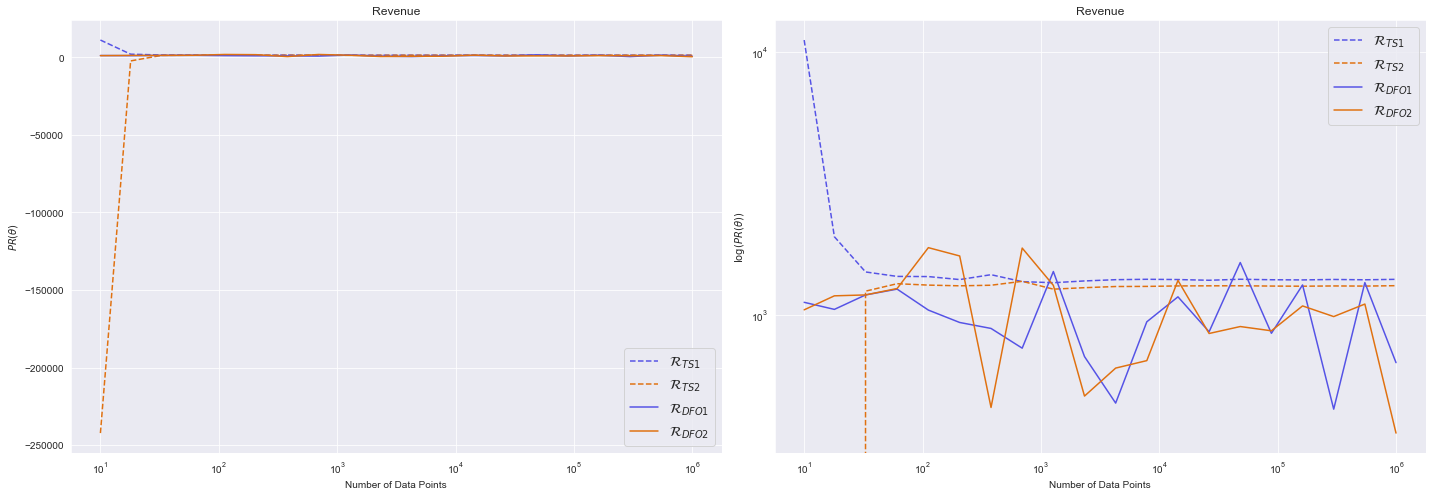

In [8]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.semilogx(num_rounds_lst, -np.squeeze(p1_risks),
             '--', color='#5553E6', label=r'$\mathcal{R}_{TS1}$')
plt.semilogx(num_rounds_lst, -np.squeeze(p2_risks),
             '--', color='#E07110', label=r'$\mathcal{R}_{TS2}$')

plt.semilogx(num_rounds_lst, -np.squeeze(p3_risks),
             '-', color='#5553E6', label=r'$\mathcal{R}_{DFO1}$')
plt.semilogx(num_rounds_lst, -np.squeeze(p4_risks),
             '-', color='#E07110', label=r'$\mathcal{R}_{DFO2}$')

plt.xlabel("Number of Data Points")
plt.ylabel(r"$PR(\theta)$")
plt.title("Revenue")
plt.legend(fontsize=14)

plt.subplot(1,2,2)
plt.loglog(num_rounds_lst, -np.squeeze(p1_risks),
           '--', color='#5553E6', label=r'$\mathcal{R}_{TS1}$')
plt.loglog(num_rounds_lst, -np.squeeze(p2_risks),
           '--', color='#E07110', label=r'$\mathcal{R}_{TS2}$')

plt.loglog(num_rounds_lst, -np.squeeze(p3_risks),
           '-', color='#5553E6', label=r'$\mathcal{R}_{DFO1}$')
plt.loglog(num_rounds_lst, -np.squeeze(p4_risks),
           '-', color='#E07110', label=r'$\mathcal{R}_{DFO2}$')

plt.xlabel("Number of Data Points")
plt.ylabel(r"$\log(PR(\theta))$")
plt.title('Revenue')
plt.legend(fontsize=14)

# plt.subplot(1,3,3)
# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p1),
#            '--', color='#5553E6', label=r'$\theta_{TS1}$')
# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p2),
#            '--', color='#E07110', label=r'$\theta_{TS2}$')

# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p3),
#            '-', color='#5553E6', label=r'$\theta_{DFO1}$')
# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p4),
#            '-', color='#E07110', label=r'$\theta_{DFO2}$')

# plt.ylim(-10,10)
# plt.xlabel("Number of Data Points")
# plt.ylabel(r"$\log(PR(\theta))$")
# plt.title('Strategies')
# plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('DD_regression_rideshare_convergence.jpg', format='jpg')
plt.show()

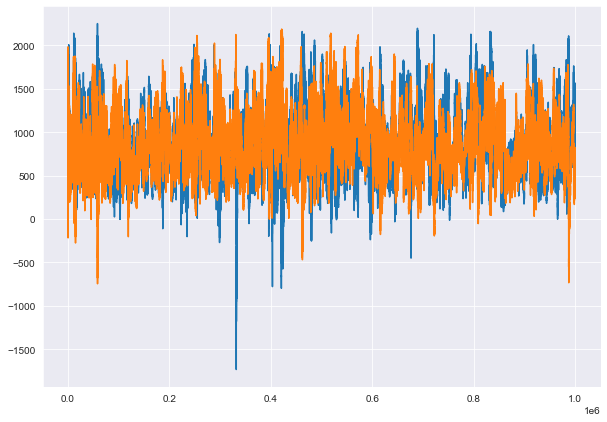

In [9]:
plt.figure(figsize=(10,7))
plt.plot(-np.squeeze(game_dfo.p1.risk_history))
plt.plot(-np.squeeze(game_dfo.p2.risk_history))
plt.show()

In [10]:
print(f'theta_1_ts - theta_1_dfo = \n{game_ts.theta_p1-game_dfo.theta_p1}')
print(f'theta_2_ts - theta_2_dfo = \n{game_ts.theta_p2-game_dfo.theta_p2}')

theta_1_ts - theta_1_dfo = 
[[ 6.86751556]
 [-2.42898346]]
theta_2_ts - theta_2_dfo = 
[[-7.13176432]
 [ 5.0388948 ]]


In [11]:
print(f'theta_1_ts = \n{game_ts.theta_p1}')
print(f'theta_2_ts = \n{game_ts.theta_p2}')

theta_1_ts = 
[[3.32684874]
 [0.04957755]]
theta_2_ts = 
[[3.32425014]
 [0.01253879]]


In [12]:
print(f'theta_1_dfo = \n{game_dfo.theta_p1}')
print(f'theta_2_dfo = \n{game_dfo.theta_p2}')

theta_1_dfo = 
[[-3.54066682]
 [ 2.47856101]]
theta_2_dfo = 
[[10.45601446]
 [-5.02635601]]


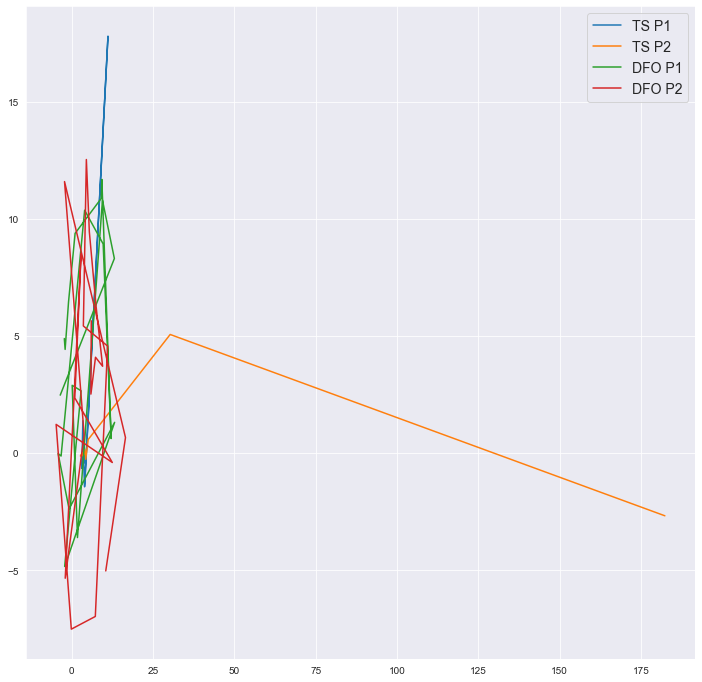

In [13]:
plt.figure(figsize=(12,12))
plt.plot(np.array(theta_final_p1)[:,0].squeeze(),
         np.array(theta_final_p1)[:,1].squeeze(), label='TS P1')
plt.plot(np.array(theta_final_p2)[:,0].squeeze(),
         np.array(theta_final_p2)[:,1].squeeze(), label='TS P2')
plt.plot(np.array(theta_final_p3)[:,0].squeeze(),
         np.array(theta_final_p3)[:,1].squeeze(), label='DFO P1')
plt.plot(np.array(theta_final_p4)[:,0].squeeze(),
         np.array(theta_final_p4)[:,1].squeeze(), label='DFO P2')
plt.legend(fontsize=14)
plt.savefig('DD_regression_rideshare_trajectory.jpg', format='jpg')
plt.show()

In [14]:
np.array(theta_final_p1)[:,0].squeeze()

array([ 3.96393071, 11.14101829,  3.92547304,  3.37253526,  4.21542707,
        3.68117293,  3.86376161,  3.41825444,  3.10224542,  3.31002121,
        3.3341572 ,  3.37780403,  3.31547372,  3.37368023,  3.34248208,
        3.32534641,  3.28234548,  3.33134915,  3.32650023,  3.32684874])

In [15]:
np.array(game_ts.p2.theta_history)[:,0].squeeze()

array([ 0.        , -0.37405865, -0.86491043, ...,  3.32413349,
        3.32419195,  3.32425014])